In [1]:
import sys
import platform
import subprocess
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, /Users/sungbeenpark/github/nitools


In [5]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, /Users/sungbeenpark/github/SUITPy


In [6]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, /Users/sungbeenpark/github


In [7]:
OS_name = platform.system()
if OS_name == 'windows':
    ## window
    dir_root = join('F:/SeqSpatialSupp_fMRI')
elif OS_name == 'Linux':
    ## Linux
    dir_root = join('/mnt/f/SeqSpatialSupp_fMRI')
elif OS_name == 'Darwin':
    ## MacOS
    dir_root = join('/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI')
print(exists(dir_root))

True


In [26]:
dir_result = join(dir_root, 'results/hist.epi.SvsR')
makedirs(dir_result, exist_ok=True)

In [9]:
tmp = [1,2,3,5,6,8,9,10,11,12,13,14]
list_nn = ['%02d'%i for i in tmp]
list_nn

['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13', '14']

---

In [10]:
nn = '01'

In [11]:
run = 1

---

### Anatomical S

In [12]:
dir_anat = join(dir_root, 'anatomicals')
exists(dir_anat)

True

In [13]:
def load_anat(subj, dir_anat):
    if len(subj)==2:
        subj = 'S'+subj
    else:
        subj = subj.replace('R','S')
    fname = join(dir_anat, subj, '%s_anatomical.nii'%subj)
    img = nb.load(fname)

    return img

In [14]:
img_anat = load_anat(nn, dir_anat)

(224, 353, 353)

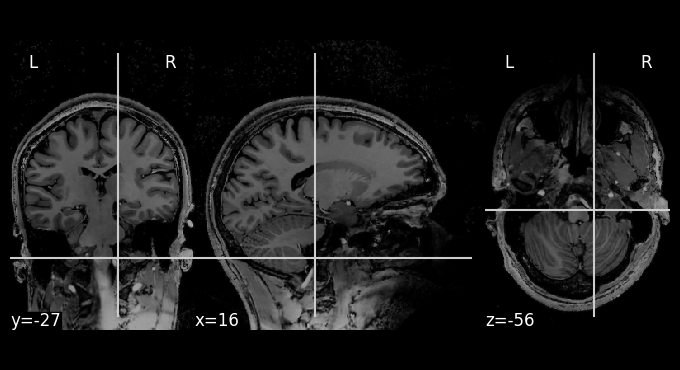

In [15]:
plotting.plot_anat(img_anat)
img_anat.shape

---

### functional S vs R

In [16]:
dir_func = join(dir_root, 'imaging_data')
exists(dir_func)

True

In [17]:
def get_affine(subj, dir_func, run=1):
    fname = join(dir_func, subj, '%s_run_%02d.nii'%(subj,run))
    
    ## AFNI
    # output = subprocess.check_output("3dinfo %s | grep -oP 'MATRIX\(\K[^)]*'"%fname, shell=True)
    # M = np.reshape(output.decode().strip().split(','), (3,4)).astype(float)
    # M = np.vstack([M, [0,0,0,1]])

    ## nilearn
    img = image.load_img(fname)
    M = img.affine
    
    return M

In [18]:
min_ = {}
max_ = {}
for ii, nn in enumerate(list_nn):
    if nn=='09':
        continue
    Ms = get_affine(subj='S'+nn, dir_func=dir_func)
    Mr = get_affine(subj='R'+nn, dir_func=dir_func)
    M_diff = Ms-Mr
    vec = np.array([1,1,1,0]).T
    res = vec.T @ (M_diff.T @ M_diff) @ vec
    print('subj %s: error = %.3f'%(nn,res))
    
    if ii == 0:
        min_['subj'] = nn
        min_['res'] = res
        max_['subj'] = nn
        max_['res'] = res
    else:
        if res>max_['res']:
            max_['subj'] = nn
            max_['res'] = res
        elif res<min_['res']:
            min_['subj'] = nn
            min_['res'] = res

if min_['subj'] != max_['subj']:
    print('Best: %s (%.4f)'%(min_['subj'],min_['res']))
    print('Worst: %s (%.4f)'%(max_['subj'],max_['res']))

subj 01: error = 0.000
subj 02: error = 0.000
subj 03: error = 0.000
subj 05: error = 0.000
subj 06: error = 0.000
subj 08: error = 0.000
subj 10: error = 0.000
subj 11: error = 0.000
subj 12: error = 0.000
subj 13: error = 0.000
subj 14: error = 0.000


In [19]:
def load_func(subj, dir_func, run=1):
    ss = subj[0]
    if ss == 'S':
        fname = join(dir_func, subj, '%s_run_%02d.nii'%(subj,run))
    elif ss == 'R':
        fname = join(dir_func, subj, '%s_run_%02d.nii'%(subj,run))
        
    img = nb.load(fname)

    return img

In [20]:
nn = '01'
img_func_S = load_func(subj='S'+nn, dir_func=dir_func, run=run)
img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run)

/opt/anaconda3/envs/SSS/lib/python3.9/site-packages/nilearn/image/resampling.py:867: UserWarning: Casting data from int32 to float32
  return resample_img(


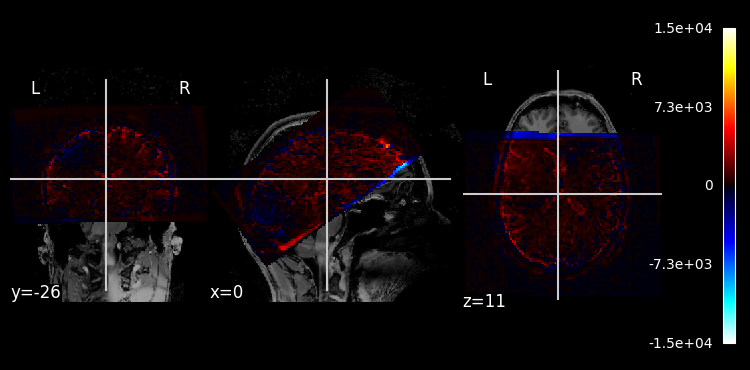

In [21]:
TR = 0
slice_S = image.index_img(img_func_S, index=TR)
slice_R = image.index_img(img_func_R, index=TR)
plotting.plot_stat_map(
    stat_map_img = image.math_img('img1 - img2', img1=slice_S, img2=slice_R),
    bg_img = img_anat
)

del img_anat

In [30]:
def plot_hist_SvsR(nn, dir_func, TR=0, dir_result=None):

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
    axs = np.concatenate(axs)
    
    for rr in range(8):
        ax = axs[rr]
        plt.sca(ax)
        
        run = rr+1
        
        img_func_S = load_func(subj='S'+nn, dir_func=dir_func, run=run)
        img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run)
        
        slice_S = image.index_img(img_func_S, index=TR)
        slice_R = image.index_img(img_func_R, index=TR)
    
        df = pd.DataFrame()
        df['S'] = slice_S.get_fdata().reshape(-1)
        df['R'] = slice_R.get_fdata().reshape(-1)
        df.replace(0., np.nan, inplace=True)
        
        sns.histplot(df, stat='percent', ax=ax)
        ax.set_ylim(0,.2)
        ax.set_title('Run%02d (Subj_ID: %s)'%(run,nn))
    
    fig.tight_layout()
    if dir_result != None:
        fig.savefig(
            join(dir_result,'fig.hist.epi.SvsR.%s.TR=%d.png'%(nn,TR)),
            dpi=300, facecolor=[1,1,1,1],
            bbox_inches='tight'
        )
        plt.close()

In [31]:
for nn in tqdm(list_nn):
    plot_hist_SvsR(nn=nn, dir_func=dir_func, TR=200, dir_result=dir_result)

100%|█████████████████████████████████████████████████████████████████████████| 12/12 [05:27<00:00, 27.26s/it]


In [ ]:
# del img_func_S, slice_S
# del img_func_R, slice_R

### functional R_orig vs R_resliced

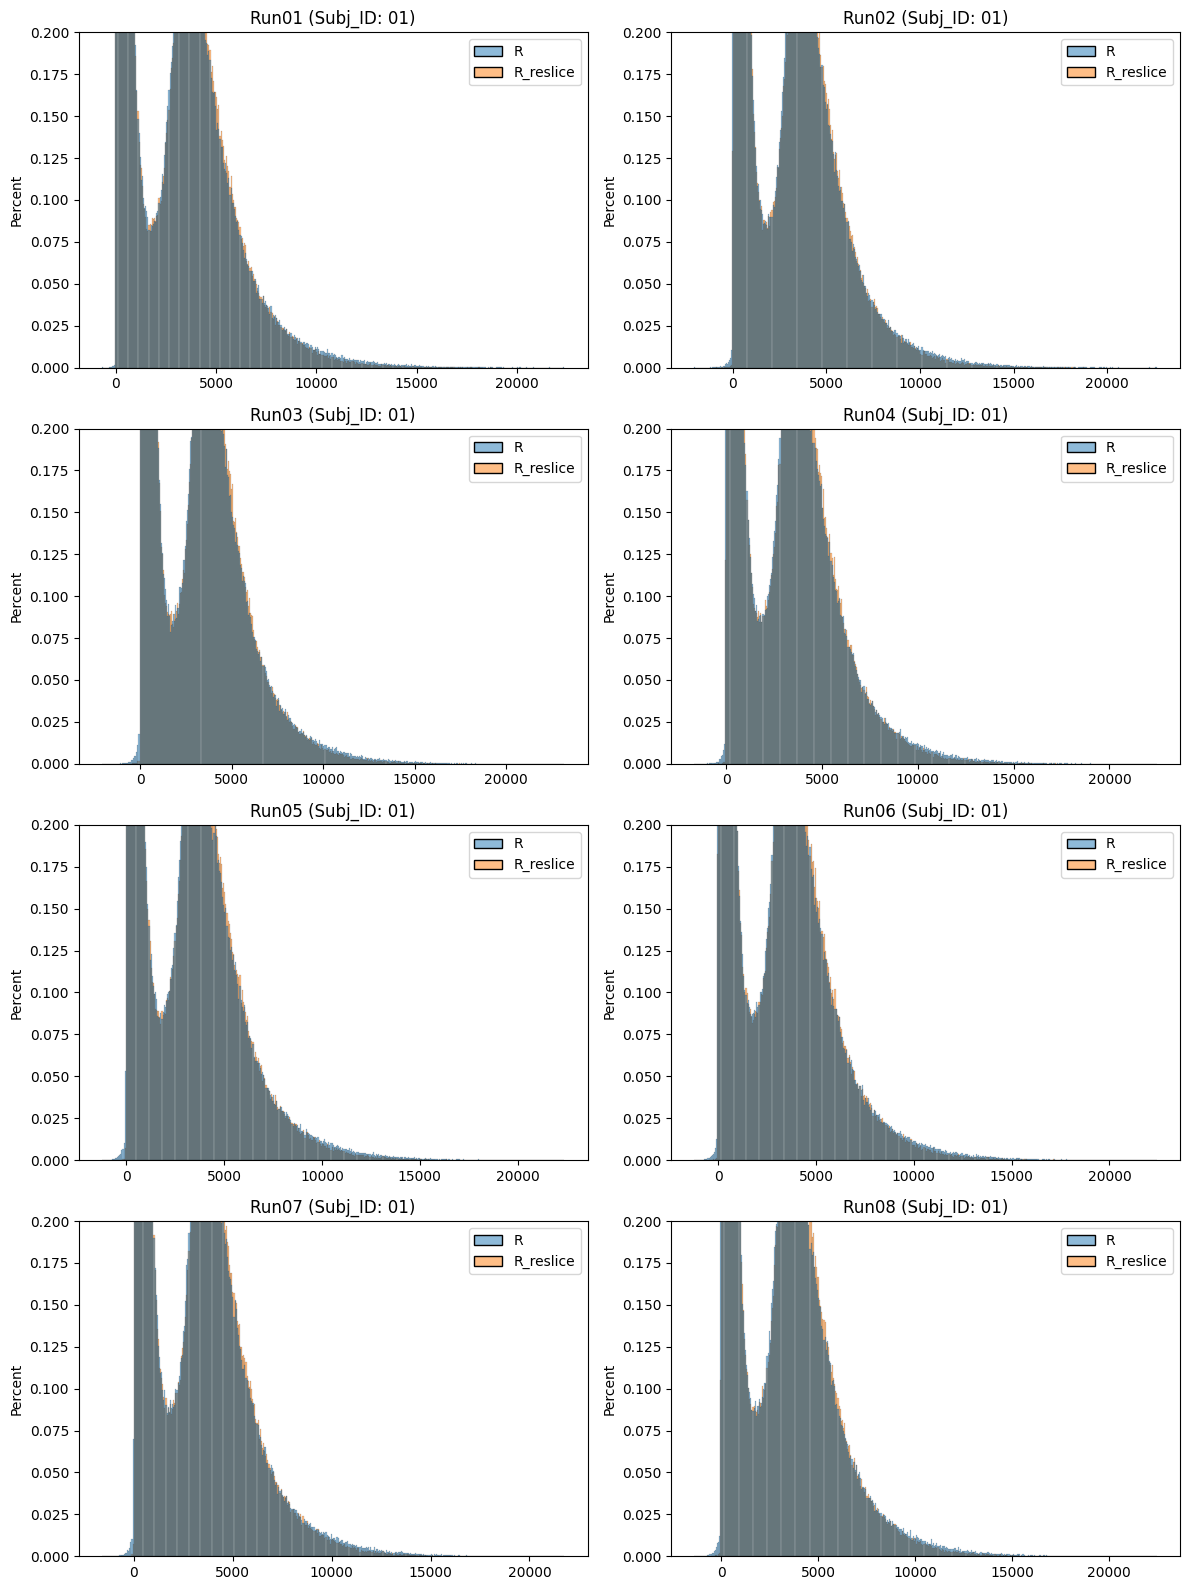

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
axs = np.concatenate(axs)

TR = 0
for rr in range(8):
    ax = axs[rr]
    run = rr+1
    
    img_func_R = load_func(subj='R'+nn, dir_func=dir_func, run=run, reslice=False)
    img_func_R_reslice = load_func(subj='R'+nn, dir_func=dir_func, run=run, reslice=True)
    
    R = image.index_img(img_func_R, index=TR)
    R_reslice = image.index_img(img_func_R_reslice, index=TR)

    df = pd.DataFrame()
    df['R'] = R.get_fdata().reshape(-1)
    df['R_reslice'] = R_reslice.get_fdata().reshape(-1)
    df.replace(0., np.nan, inplace=True)
    
    sns.histplot(df, stat='percent', ax=ax)
    ax.set_ylim(0,.2)
    ax.set_title('Run%02d (Subj_ID: %s)'%(run,nn))

fig.tight_layout()

In [24]:
del img_func_R, R
del img_func_R_reslice, R_reslice

---